# Autoencoder architecture implementation

This notebook implements the autoencoder architecture using the simple MNIST datset. It uses a simple convolutional neural network that compresses images and tries to reconstruct them from the compressed state.

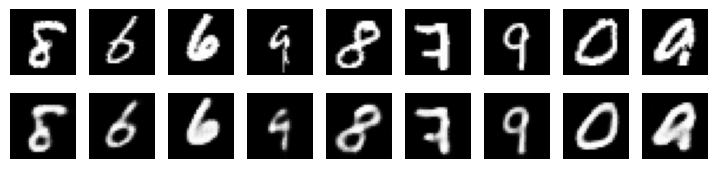

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Read the data

In [ ]:
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

### Build the model

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
num_epochs = 3
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0113
Epoch:2, Loss:0.0045
Epoch:3, Loss:0.0039


### Plot the images
In the top row, we plot the original images.
In the bottom row, we plot the reconstructed images, hence the blurriness.

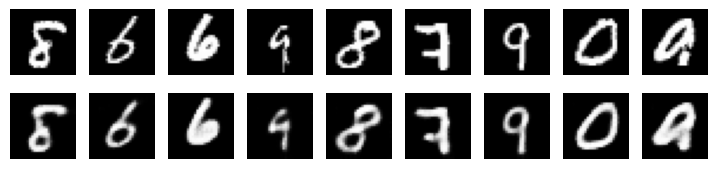

In [ ]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item: 1, 28, 28
        plt.imshow(item[0])
        plt.axis('off')

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item: 1, 28, 28
        plt.imshow(item[0])
        plt.axis('off')